# Neural Collapse and Data Distillatioin

This notebook implements data distillation with neural collapse by only one step. The main papers considered here are https://github.com/SsnL/dataset-distillation and https://github.com/tding1/Neural-Collapse. The neural network is firstly trained to its terminal phase and then distills synthesized data as introduced. Below we configure our path to the dataset distillation packages from https://github.com/SsnL/dataset-distillation.

# Import

In [1]:
!git clone https://github.com/SongzeYang0721/Data_Distillation_and_Neural_Collpase.git

Cloning into 'Data_Distillation_and_Neural_Collpase'...
remote: Enumerating objects: 728, done.
remote: Counting objects: 100% (469/469), done.
remote: Compressing objects: 100% (240/240), done.
^Cceiving objects:  14% (103/728), 3.05 MiB | 1.01 MiB/s    
fetch-pack: unexpected disconnect while reading sideband packet


In [2]:
import sys
sys.path.append('/content/Data_Distillation_and_Neural_Collpase/')

In [14]:
# !pip install --upgrade wandb
import wandb
wandb.login()

wandb: Currently logged in as: yangsongze2008 (data-distillation-with-nc). Use `wandb login --relogin` to force relogin


True

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
import torch.nn.functional as F

import numpy as np
import pickle
import scipy.linalg as scilin

Let's import the file from the https://github.com/tding1/Neural-Collapse.

In [33]:
import models
from models.res_adapt import ResNet18_adapt
from utils import *
import train_1st_order
from train_2nd_order import weight_decay
from validate_NC import compute_Wh_b_relation, compute_W_H_relation, compute_ETF, compute_Sigma_B, compute_Sigma_W,compute_info,FCFeatures
from data.datasets import make_dataset
from arg_loader import *

# Load Parameters

In [68]:
# architecture params
model='resnet50'
bias=True
ETF_fc=False
fixdim=0
SOTA=True

# MLP settings (only when using mlp and res_adapt(in which case only width has effect))
width=1024
depth=6

# hardware settings
gpu_id=0
seed=6
use_cudnn=True

# dataset
dataset='cifar10'
data_dir='~/data'
uid="Resnet50-SGD"
force=True

# learning options
epochs = 1
batch_size=32
loss = 'CrossEntropy'
sample_size = None

# optimization
lr=0.001
optimizer = "Adam"
device = "mps"
check = False

In [69]:
args = train_args(model=model,bias=bias,ETF_fc=ETF_fc,fixdim=fixdim,SOTA=SOTA,
                  width=width,depth=depth,
                  gpu_id=gpu_id,seed=seed,use_cudnn=use_cudnn,
                  dataset=dataset,data_dir=data_dir,uid=uid,force=force,
                  epochs=epochs,batch_size = batch_size,loss = loss,sample_size=sample_size,
                  lr = lr,optimizer=optimizer,
                  device = device)

override this uidResnet50-SGD
cudnn is used


In [70]:
if device == "cuda":
    torch.cuda.empty_cache()
if check:
    torch.cuda.memory_allocated()

# Load Dataset

In [71]:
trainloader, testloader, num_classes = make_dataset(dataset, 
                                           data_dir, 
                                           batch_size, 
                                           SOTA=SOTA)
print(num_classes)
# config["num_classes"] = num_classes

Dataset: CIFAR10.
Files already downloaded and verified
Files already downloaded and verified
10


In [72]:
images, labels = next(iter(trainloader))
size_train, channels, height, width = images.shape
nc = channels
input_size = height, width
print("The number of class in our training set is ", num_classes)
print("Batch size:", size_train, "Number of channels:", channels, "input height:", height, "input width:", width)

The number of class in our training set is  10
Batch size: 32 Number of channels: 3 input height: 32 input width: 32


# Load Model

In [73]:
if args.model == "MLP":
    model = models.__dict__[args.model](hidden = args.width, depth = args.depth, fc_bias=args.bias, num_classes=num_classes).to(args.device)
elif args.model == "ResNet18_adapt":
    model = ResNet18_adapt(width = args.width, num_classes=num_classes, fc_bias=args.bias).to(args.device)
else:
    model = models.__dict__[args.model](num_classes=num_classes, fc_bias=args.bias, ETF_fc=args.ETF_fc, fixdim=args.fixdim, SOTA=args.SOTA).to(args.device)

print('# of model parameters: ' + str(count_network_parameters(model)))
print(type(model))

# of model parameters: 23520842
<class 'models.resnet.ResNet'>


# Model Training

In [74]:
def trainer(args, model, trainloader, epoch_id, criterion, optimizer, scheduler, logfile):

    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    print_and_save('\nTraining Epoch: [%d | %d] LR: %f' % (epoch_id + 1, args.epochs, scheduler.get_last_lr()[-1]), logfile)
    for batch_idx, (inputs, targets) in enumerate(trainloader):

        inputs, targets = inputs.to(args.device), targets.to(args.device)

        model.train()
        outputs = model(inputs)
        
        if args.sep_decay:
            loss = loss_compute(args, model, criterion, outputs, targets)
        else:
            if args.loss == 'CrossEntropy':
                loss = criterion(outputs[0], targets)
            elif args.loss == 'MSE':
                loss = criterion(outputs[0], nn.functional.one_hot(targets).type(torch.FloatTensor).to(args.device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure accuracy and record loss
        model.eval()
        outputs = model(inputs)
        prec1, prec5 = compute_accuracy(outputs[0].detach().data, targets.detach().data, topk=(1, 5))
        losses.update(loss.item(), inputs.size(0))
        top1.update(prec1.item(), inputs.size(0))
        top5.update(prec5.item(), inputs.size(0))

#         if batch_idx % 10 == 0:
    print('[epoch: %d] (%d/%d) | Loss: %.4f | top1: %.4f | top5: %.4f ' %
          (epoch_id + 1, batch_idx + 1, len(trainloader), losses.avg, top1.avg, top5.avg))


    wandb.log({
        "losses.avg":losses.avg, 
        "top1.avg":top1.avg,
        "top5.avg":top5.avg
    })

    scheduler.step()


In [12]:
def train(args, model, trainloader):

    criterion = make_criterion(args)
    optimizer = make_optimizer(args, model)
    scheduler = make_scheduler(args, optimizer)

    logfile = open('%s/train_log.txt' % (args.save_path), 'w')

    print_and_save('# of model parameters: ' + str(count_network_parameters(model)), logfile)
    print_and_save('--------------------- Training -------------------------------', logfile)
    for epoch_id in range(args.epochs):

        trainer(args, model, trainloader, epoch_id, criterion, optimizer, scheduler, logfile)
        torch.save(model.state_dict(), args.save_path + "/epoch_" + str(epoch_id + 1).zfill(3) + ".pth")

    logfile.close()

# Validation of Neural Collapse

In [13]:
def evaluate_NC(args,model,testloader):
    
    args.load_path = "model_weights/"+uid+"/"

    fc_features = FCFeatures()
    model.fc.register_forward_pre_hook(fc_features)
    info_dict = {
            'collapse_metric': [],
            'ETF_metric': [],
            'WH_relation_metric': [],
            'Wh_b_relation_metric': [],
            'W': [],
            'b': [],
            'H': [],
            'mu_G_train': [],
            # 'mu_G_test': [],
            'train_acc1': [],
            'train_acc5': [],
            'test_acc1': [],
            'test_acc5': []
        }

    logfile = open('%s/test_log.txt' % (args.load_path), 'w')
    print_and_save('--------------------- Evaluating -------------------------------', logfile)
    for i in range(args.epochs):
        
        
        map_location=torch.device(args.device)
        model.load_state_dict(torch.load(args.load_path + 'epoch_' + str(i + 1).zfill(3) + '.pth', 
                                         map_location=map_location))

        
#         model.load_state_dict(torch.load(args.load_path + 'epoch_' + str(i + 1).zfill(3) + '.pth'),map_location)
        model.eval()

        for n, p in model.named_parameters():
            if 'fc.weight' in n:
                W = p
            if 'fc.bias' in n:
                b = p

        mu_G_train, mu_c_dict_train, train_acc1, train_acc5 = compute_info(args, model, fc_features, trainloader, isTrain=True)
        mu_G_test, mu_c_dict_test, test_acc1, test_acc5 = compute_info(args, model, fc_features, testloader, isTrain=False)

        Sigma_W = compute_Sigma_W(args, model, fc_features, mu_c_dict_train, trainloader, isTrain=True)
        # Sigma_W_test_norm = compute_Sigma_W(args, model, fc_features, mu_c_dict_train, testloader, isTrain=False)
        Sigma_B = compute_Sigma_B(mu_c_dict_train, mu_G_train)

        collapse_metric = np.trace(Sigma_W @ scilin.pinv(Sigma_B)) / len(mu_c_dict_train)
        ETF_metric = compute_ETF(W)
        WH_relation_metric, H = compute_W_H_relation(W, mu_c_dict_train, mu_G_train)
        if args.bias:
            Wh_b_relation_metric = compute_Wh_b_relation(W, mu_G_train, b)
        else:
            Wh_b_relation_metric = compute_Wh_b_relation(W, mu_G_train, torch.zeros((W.shape[0], )))

        info_dict['collapse_metric'].append(collapse_metric)
        info_dict['ETF_metric'].append(ETF_metric)
        info_dict['WH_relation_metric'].append(WH_relation_metric)
        info_dict['Wh_b_relation_metric'].append(Wh_b_relation_metric)

        info_dict['W'].append((W.detach().cpu().numpy()))
        if args.bias:
            info_dict['b'].append(b.detach().cpu().numpy())
        info_dict['H'].append(H.detach().cpu().numpy())

        info_dict['mu_G_train'].append(mu_G_train.detach().cpu().numpy())
        # info_dict['mu_G_test'].append(mu_G_test.detach().cpu().numpy())

        info_dict['train_acc1'].append(train_acc1)
        info_dict['train_acc5'].append(train_acc5)
        info_dict['test_acc1'].append(test_acc1)
        info_dict['test_acc5'].append(test_acc5)


        print_and_save('[epoch: %d] | collapsemetric: %.4f | ETF metric: %.4f | WH metric: %.4f | Wh_b metric: %.4f ' %
                        (i + 1, collapse_metric, ETF_metric, WH_relation_metric, Wh_b_relation_metric), logfile)

        print_and_save('[epoch: %d] | train top1: %.4f | train top5: %.4f | test top1: %.4f | test top5: %.4f ' %
                        (i + 1, train_acc1, train_acc5, test_acc1, test_acc5), logfile)

        wandb.log({
                       "train_acc1":train_acc1, 
                       "train_acc5":train_acc5,
                       "test_acc1":test_acc1,
                       "test_acc5":test_acc5
                    })

        wandb.log({"collapse_metric":collapse_metric, 
                       "ETF_metric":ETF_metric, 
                       "WH_relation_metric":WH_relation_metric,
                       "Wh_b_relation_metric":Wh_b_relation_metric
                    })


    with open(args.load_path + 'info.pkl', 'wb') as f:
        pickle.dump(info_dict, f)

# Create a experiment on weights&biases

In [ ]:
import time

# Start timer
start_time = time.time()

# Code to be timed here:
config = {
    # architecture params
    "model":model,
    "bias": bias,
    "ETF_fc":ETF_fc,
    "fixdim":fixdim,
    "SOTA":SOTA,
    
    # MLP settings (only when using mlp and res_adapt(in which case only width has effect))
    "width":width,
    "depth":depth,
    
    # hardware settings
    "gpu_id":gpu_id,
    "seed":seed,
    "use_cudnn":use_cudnn,
    
    # dataset
    "dataset":dataset,
    "data_dir":data_dir,
    "uid":uid,
    "force":force,
    
    # learning options
    "epochs": epochs,
    "batch_size":batch_size,
    "loss": loss,
    "sample_size": sample_size,
    
    # optimization
    "lr":lr,
    "optimizer":optimizer,
    "device" :device
}

run = wandb.init(
    project="DD&NC",
    notes="Better Network Design",
    tags=["Epochs: 200","Resnet18","Adam","cifar10"],
    config= config
)

train(args,model,trainloader)
evaluate_NC(args,model,testloader)
    
# End timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
elapsed_time_minutes = elapsed_time / 60
print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")
wandb.finish()

# Find the ETF center

## Visualization of K-ETF

A (K-Simplex ETF) is a collection of points in $R^K$ specified by the columns of:

$$
M = \sqrt\frac{K}{K-1} (I_K - \frac{1}{K}1_K1_K^T)
$$

In [44]:
def k_etf(K=10):
    constant = torch.sqrt(torch.tensor(K/(K-1)))
    ETF = (torch.eye(K)-(1/K)*torch.ones((K, K)))
    return constant*ETF

def k_etf_normalize(K=10):
    constant = torch.sqrt(torch.tensor(K/(K-1)))
    ETF = (torch.eye(K)-(1/K)*torch.ones((K, K)))
    norm = torch.sqrt((1/K*torch.norm(constant*ETF, 'fro')**2))
    return constant*ETF/norm

In [48]:
print(k_etf(K=10))

tensor([[ 0.9487, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054,  0.9487, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054,  0.9487, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054,  0.9487, -0.1054, -0.1054, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054, -0.1054,  0.9487, -0.1054, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054, -0.1054, -0.1054,  0.9487, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,  0.9487, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,  0.9487,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,
          0.9487, -0.1054],
        [-0.1054, -

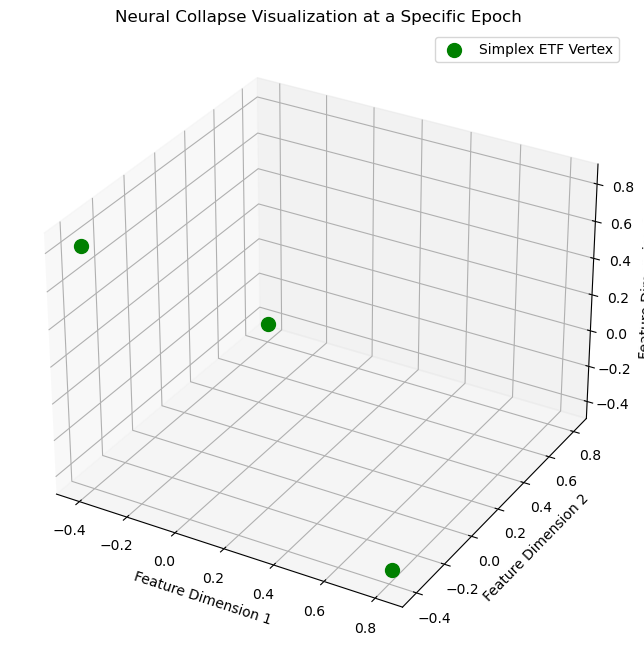

In [46]:
# Let's generate some sample data to visualize the concepts

# Define the simplex ETF vertices (4 vertices for a 3-simplex)
simplex_vertices = k_etf(3)

classifier_directions = np.random.randn(*simplex_vertices.shape)

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting simplex ETF vertices as green spheres
for vertex in simplex_vertices:
    ax.scatter(*vertex, color='green', s=100, marker='o', label='Simplex ETF Vertex')

# Labels and legend
ax.set_xlabel('Feature Dimension 1')
ax.set_ylabel('Feature Dimension 2')
ax.set_zlabel('Feature Dimension 3')
plt.title('Neural Collapse Visualization at a Specific Epoch')

# Simplify the legend
handles, labels = ax.get_legend_handles_labels()
unique_labels = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax.legend(*zip(*unique_labels))

plt.show()


## Analysis of Features

The improved neural network design shows us that we can fix the weight matrix $W$ as K-ETF and set the feature dimension $d$ equal to $k$, the number of class. We can plot this ETF and see if it matches.

In [47]:
W = torch.sqrt(torch.tensor(num_classes/(num_classes-1)))*(torch.eye(num_classes)-(1/num_classes)*torch.ones((num_classes, num_classes)))
W /= torch.sqrt((1/num_classes*torch.norm(W, 'fro')**2))
print(W)

tensor([[ 0.9487, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054,  0.9487, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054,  0.9487, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054,  0.9487, -0.1054, -0.1054, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054, -0.1054,  0.9487, -0.1054, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054, -0.1054, -0.1054,  0.9487, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,  0.9487, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,  0.9487,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,
          0.9487, -0.1054],
        [-0.1054, -

### Further Explaination

The neural collapse shows that as training proceeds, last-layer features $H$ collapse onto their class means ($NC1$), class means converge to the vertices of the simplex ETF ($NC2$), and the linear classifiers $W$ approach their corresponding class means ($NC3$). 

In the collapse stage, the $NC2$ says that the class-means centered at their global means form a Simplex Equiangular Tight Frame - or Simplex ETF. More specifically, the weigths matrix $W^{*T} \in R^{d \times d}$ with $U^TU = I_d$, the normalised matrix $M:=\frac{1}{w^*}UW^{*T}$

$$
M^TM = \frac{K}{K-1} (I_K - \frac{1}{K}1_K1_K^T)
$$

Depending on whether to fix the output dimension, we will get shapeful $W \in R^{k \times d}$ and $H \in R^{d \times N}$. The dimension of bias in the last linear layer is always fixed at $b \in R^{k \times N}$. Define $N=nk$ and k is the number of classes and n is the number of images (input data) in each class.

If we fixed the $W$, it is easy to show that the class means will converge to a standard K-ETF.

In [79]:
args.load_path = "model_weights/"+uid+"/"

fc_features = FCFeatures()
model.fc.register_forward_pre_hook(fc_features)

print('--------------------- Evaluating -------------------------------')

### investigate a specific epochs
i = 199
###

map_location=torch.device(args.device)
model.load_state_dict(torch.load(args.load_path + 'epoch_' + str(i + 1).zfill(3) + '.pth', 
                                 map_location=map_location))

model.eval()

for n, p in model.named_parameters():
    if 'fc.weight' in n:
        W = p
    if 'fc.bias' in n:
        b = p
        
print("W is", W)
print("THe shape of our weigths in this epochs is ", W.shape)    
        
mu_G_train, mu_c_dict_train, train_acc1, train_acc5 = compute_info(args, model, fc_features, trainloader, isTrain=True)
mu_G_test, mu_c_dict_test, test_acc1, test_acc5 = compute_info(args, model, fc_features, testloader, isTrain=False)

Sigma_W = compute_Sigma_W(args, model, fc_features, mu_c_dict_train, trainloader, isTrain=True)
# Sigma_W_test_norm = compute_Sigma_W(args, model, fc_features, mu_c_dict_train, testloader, isTrain=False)
Sigma_B = compute_Sigma_B(mu_c_dict_train, mu_G_train)

collapse_metric = np.trace(Sigma_W @ scilin.pinv(Sigma_B)) / len(mu_c_dict_train)
ETF_metric = compute_ETF(W)
WH_relation_metric, H = compute_W_H_relation(W, mu_c_dict_train, mu_G_train)

print(H.shape)

if args.bias:
    Wh_b_relation_metric = compute_Wh_b_relation(W, mu_G_train, b)
else:
    Wh_b_relation_metric = compute_Wh_b_relation(W, mu_G_train, torch.zeros((W.shape[0], )))


print('[epoch: %d] | collapsemetric: %.4f | ETF metric: %.4f | WH metric: %.4f | Wh_b metric: %.4f ' %
                (i + 1, collapse_metric, ETF_metric, WH_relation_metric, Wh_b_relation_metric))

print('[epoch: %d] | train top1: %.4f | train top5: %.4f | test top1: %.4f | test top5: %.4f ' %
                (i + 1, train_acc1, train_acc5, test_acc1, test_acc5))


--------------------- Evaluating -------------------------------
W is Parameter containing:
tensor([[-0.0072, -0.0109, -0.0203,  ..., -0.0434, -0.0099, -0.0008],
        [-0.0091,  0.0641, -0.0151,  ...,  0.0376,  0.1295, -0.0054],
        [-0.0167, -0.0202, -0.0182,  ..., -0.0663, -0.0129,  0.0454],
        ...,
        [-0.0194, -0.0208,  0.0542,  ..., -0.0456, -0.0114, -0.0061],
        [ 0.1145,  0.0651, -0.0118,  ..., -0.0446, -0.0193, -0.0120],
        [-0.0101, -0.0158, -0.0168,  ...,  0.3777, -0.0046, -0.0084]],
       device='mps:0', requires_grad=True)
THe shape of our weigths in this epochs is  torch.Size([10, 2048])


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x10be3e8e0>
Traceback (most recent call last):
  File "/Users/songzeyang/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/Users/songzeyang/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/songzeyang/anaconda3/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/songzeyang/anaconda3/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/songzeyang/anaconda3/lib/python3.11/multiprocessing/connection.py", line 930, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/so

KeyboardInterrupt: 

# Data Distillation

Let's distill our data with the neural collapse weight. The weight is frozen throughout the distillation process.

In [26]:
def generate_distilled_images(model, args, num_classes=10, 
                              num_images_per_class=10, 
                              image_shape=(3, 28, 28), 
                              device="cpu"):
    criterion = nn.CrossEntropyLoss()  # Define the loss function

    model.eval()  # Ensure the model is in evaluation mode

    # Labels
    labels = torch.arange(num_classes, dtype=torch.long, device=device) \
                .repeat_interleave(num_images_per_class)

    # Data
    distilled_images = nn.ParameterList()
    initial_images = []  # List to store the initial state of images
    for _ in range(num_classes * num_images_per_class):
        img = torch.rand(image_shape, device=device)
        initial_images.append(img.clone())  # Clone and store the initial state
        distilled_images.append(nn.Parameter(img))  # Add as a parameter for optimization

    # Optimizer
    optimizer = optim.Adam(distilled_images.parameters(), lr=0.01)

    # Distillation process
    for _ in range(10000):  # Number of optimization steps
        optimizer.zero_grad()
        images_tensor = torch.cat([img.unsqueeze(0) for img in distilled_images])
        output = model(images_tensor)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

    # Detach the images from the graph for output
    final_distilled_images = [img.detach() for img in distilled_images]
    return initial_images, final_distilled_images, labels

# Example usage
device = "cpu"  # Change to "cuda" if using GPU
model = LeNet(nc, num_classes=10, input_size=input_size[0]) 
model.to(device)
initial_data, distilled_images, distilled_labels = generate_distilled_images(
    model, 
    num_classes=10, 
    num_images_per_class=1, 
    image_shape=(nc, input_size[0], input_size[1]), 
    device=device
)


Let's visualize our distilled image.

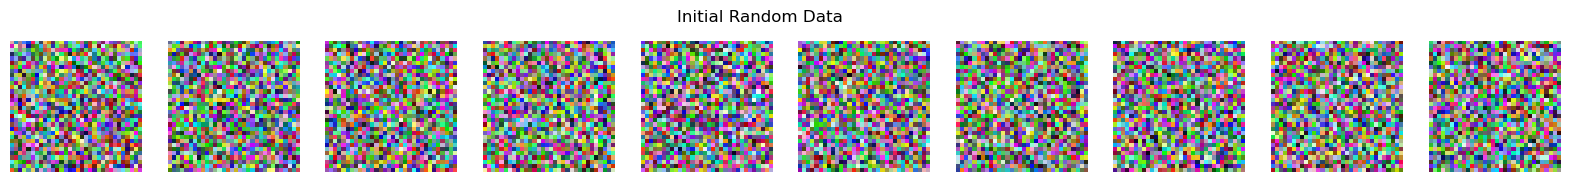

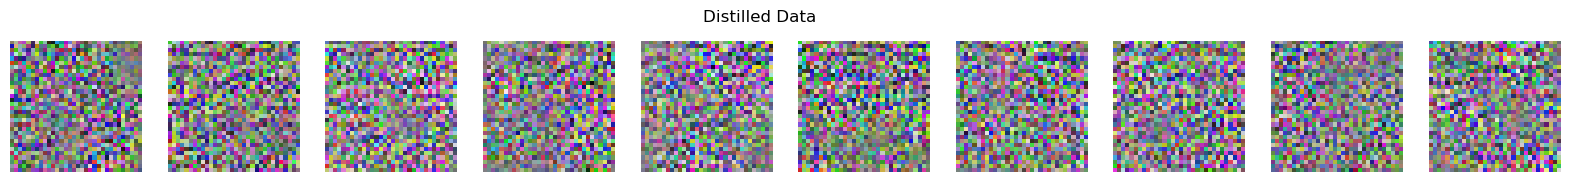

In [27]:
import matplotlib.pyplot as plt

def plot_images(data, title="Images", num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    fig.suptitle(title)

    for i, ax in enumerate(axes):
        # Detach the tensor, move to CPU, convert to numpy, and transpose dimensions
        # Transpose from (C, H, W) to (H, W, C)
        image = data[i].detach().cpu().numpy().transpose(1, 2, 0)
        
        # Normalize the image to [0, 1] for correct visualization
        image = (image - image.min()) / (image.max() - image.min())

        ax.imshow(image)
        ax.axis('off')

    plt.show()

# Example usage (assuming initial_data and distilled_images are lists of tensors)
# Plot initial data
plot_images(initial_data, title="Initial Random Data")

# Plot distilled data
plot_images(distilled_images, title="Distilled Data")



In [36]:
def generate_distilled_images(model, num_classes=10, num_images_per_class=10, image_shape=(3, 28, 28), device="cpu"):
    criterion = nn.CrossEntropyLoss()  # Define the loss function

    model.eval()  # Ensure the model is in evaluation mode

    # Labels
    labels = torch.arange(num_classes, dtype=torch.long, device=device) \
                .repeat_interleave(num_images_per_class)
    print(labels)

    # Data
    distilled_images = nn.ParameterList()
    initial_images = []  # List to store the initial state of images
    for _ in range(num_classes * num_images_per_class):
        img = torch.rand(image_shape, device=device)
        initial_images.append(img.clone())  # Clone and store the initial state
        distilled_images.append(nn.Parameter(img))  # Add as a parameter for optimization

    # Optimizer
    optimizer = optim.Adam(distilled_images.parameters(), lr=0.01)

    # Distillation process
    for _ in range(10000):  # Number of optimization steps
        optimizer.zero_grad()
        images_tensor = torch.cat([img.unsqueeze(0) for img in distilled_images])
        outputs = model(images_tensor)
        if args.loss == 'CrossEntropy':
            loss = criterion(outputs[0], labels) + weight_decay(args, model)
        elif args.loss == 'MSE':
            loss = criterion(outputs[0], nn.functional.one_hot(labels).type(torch.FloatTensor).to(args.device)) \
                   + weight_decay(args, model)
#         loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

    # Detach the images from the graph for output
    final_distilled_images = [img.detach() for img in distilled_images]
    return initial_images, final_distilled_images, labels

# Example usage
device = "cpu"  # Change to "cuda" if using GPU
model.to(device)
initial_data, distilled_images, distilled_labels = generate_distilled_images(
    model, 
    num_classes=10, 
    num_images_per_class=1, 
    image_shape=(nc, input_size[0], input_size[1]), 
    device=device
)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


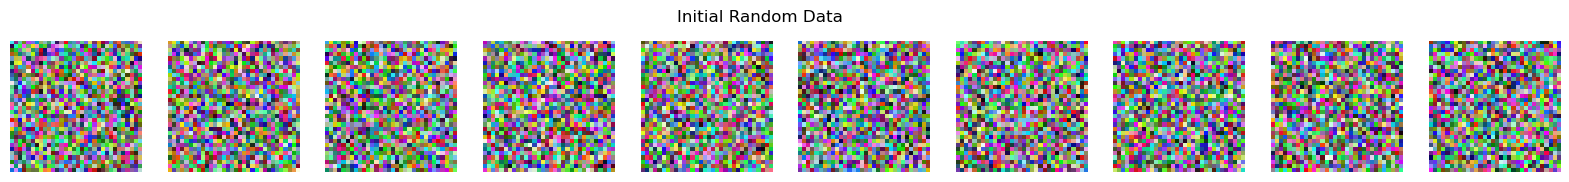

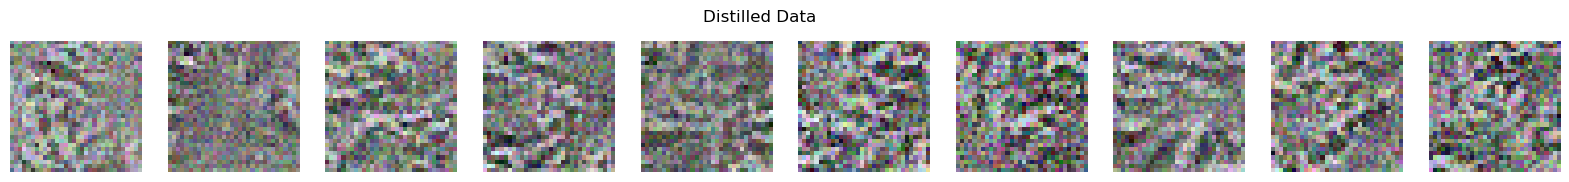

In [37]:
import matplotlib.pyplot as plt

def plot_images(data, title="Images", num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    fig.suptitle(title)

    for i, ax in enumerate(axes):
        # Detach the tensor, move to CPU, convert to numpy, and transpose dimensions
        # Transpose from (C, H, W) to (H, W, C)
        image = data[i].detach().cpu().numpy().transpose(1, 2, 0)
        
        # Normalize the image to [0, 1] for correct visualization
        image = (image - image.min()) / (image.max() - image.min())

        ax.imshow(image)
        ax.axis('off')

    plt.show()

# Example usage (assuming initial_data and distilled_images are lists of tensors)
# Plot initial data
plot_images(initial_data, title="Initial Random Data")

# Plot distilled data
plot_images(distilled_images, title="Distilled Data")
